In [2]:
import pandas as pd
import numpy as np

from dataprep.clean import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from optuna import create_study, visualization
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
import shap
import kaleido
# import plotly.io as pio
# pio.kaleido.scope.default_format = "svg"
import matplotlib.pyplot as plt
import joblib

import machine_learning_pipeline as mlp
%load_ext autoreload
%autoreload 2

c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\Dell\AppData\Local\Temp/ipykernel_24680/1090608179.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466


### Data Wrangling

#### Loading train and test dfs

In [3]:
dataset_folder = 'S4 E4 Regression wirh an Abalone Dataset'

train_df = pd.read_csv(f'{dataset_folder}/train.csv')
test_df = pd.read_csv(f'{dataset_folder}/test.csv')

# cleaning the headers
train_df = clean_headers(train_df)
# confirming the id is unique for each row and setting it 
# as the index
assert train_df.id.nunique() == len(train_df)
train_df = train_df.set_index('id')

test_df = clean_headers(test_df)
assert test_df.id.nunique() == len(test_df)
test_df = test_df.set_index('id')

train_df

Column Headers Cleaning Report:
	9 values cleaned (90.0%)
Column Headers Cleaning Report:
	8 values cleaned (88.89%)


sex  length  diameter  height  whole_weight  whole_weight_1  \
id                                                                  
0       F   0.550     0.430   0.150        0.7715          0.3285   
1       F   0.630     0.490   0.145        1.1300          0.4580   
2       I   0.160     0.110   0.025        0.0210          0.0055   
3       M   0.595     0.475   0.150        0.9145          0.3755   
4       I   0.555     0.425   0.130        0.7820          0.3695   
...    ..     ...       ...     ...           ...             ...   
90610   M   0.335     0.235   0.075        0.1585          0.0685   
90611   M   0.555     0.425   0.150        0.8790          0.3865   
90612   I   0.435     0.330   0.095        0.3215          0.1510   
90613   I   0.345     0.270   0.075        0.2000          0.0980   
90614   I   0.425     0.325   0.100        0.3455          0.1525   

       whole_weight_2  shell_weight  rings  
id                                          
0              0.1465        0.2400     11  
1              0.2765        0.3200     11  
2              0.0030        0.0050      6  
3              0.2055        0.2500     10  
4              0.1600        0.1975      9  
...               ...           ...    ...  
90610          0.0370        0.0450      6  
90611          0.1815        0.2400      9  
90612          0.0785        0.0815      6  
90613          0.0490        0.0700      6  
90614          0.0785        0.1050      8  

[90615 rows x 9 columns]

#### Handling the Target/Dependent Variable

In [4]:
target = 'rings'
# defining the type of our target: 'continuous', 'binary' or 'multiclass'
target_type = 'continuous'

# checking that the target_type is a valid one
assert target_type in ['continuous', 'binary', 'multiclass']

# encoding the target for categorical string target columns
if target_type != 'continuous':
    le = LabelEncoder()
    train_df[target] = le.fit_transform(train_df[target].tolist())
    target_classes = list(le.classes_)
    print('Target Encoding:')
    for i, clss in enumerate(target_classes): print(target + ' ' + str(clss) + ' -> ' + target + ' ' + str(i)) 

#### Splitting features into numerical and categorical types

In [5]:
# creating a dataframe that lets us know the data types of each one of our 
# features
data_types = pd.DataFrame(train_df.dtypes, columns=['feature_type'])
data_types['unique_values'] = train_df.nunique()
data_types

feature_type  unique_values
sex                  object              3
length              float64            157
diameter            float64            126
height              float64             90
whole_weight        float64           3175
whole_weight_1      float64           1799
whole_weight_2      float64            979
shell_weight        float64           1129
rings                 int64             28

Although all the columns are numeric, the small number of diffetent values for some columns suggests that the they could be interpreted as categorical

In [6]:
# setting a threshold to determine categorical columns versus numerical
cat_threshold = 10
numerical_features, categorical_features = mlp.split_features(df=train_df, target_col=target, categorical_threshold=cat_threshold)

The numerical features are: ['length', 'diameter', 'height', 'whole_weight', 'whole_weight_1', 'whole_weight_2', 'shell_weight']
The categorical features are: ['sex']


### EDA

#### Pairplot
These graphs help us visualize the relationships between our numerical features and the target. For numerical targets the last row of the pairplot corresponds to the target; for categorical targets, the target can be seen as the marker color in each graph.

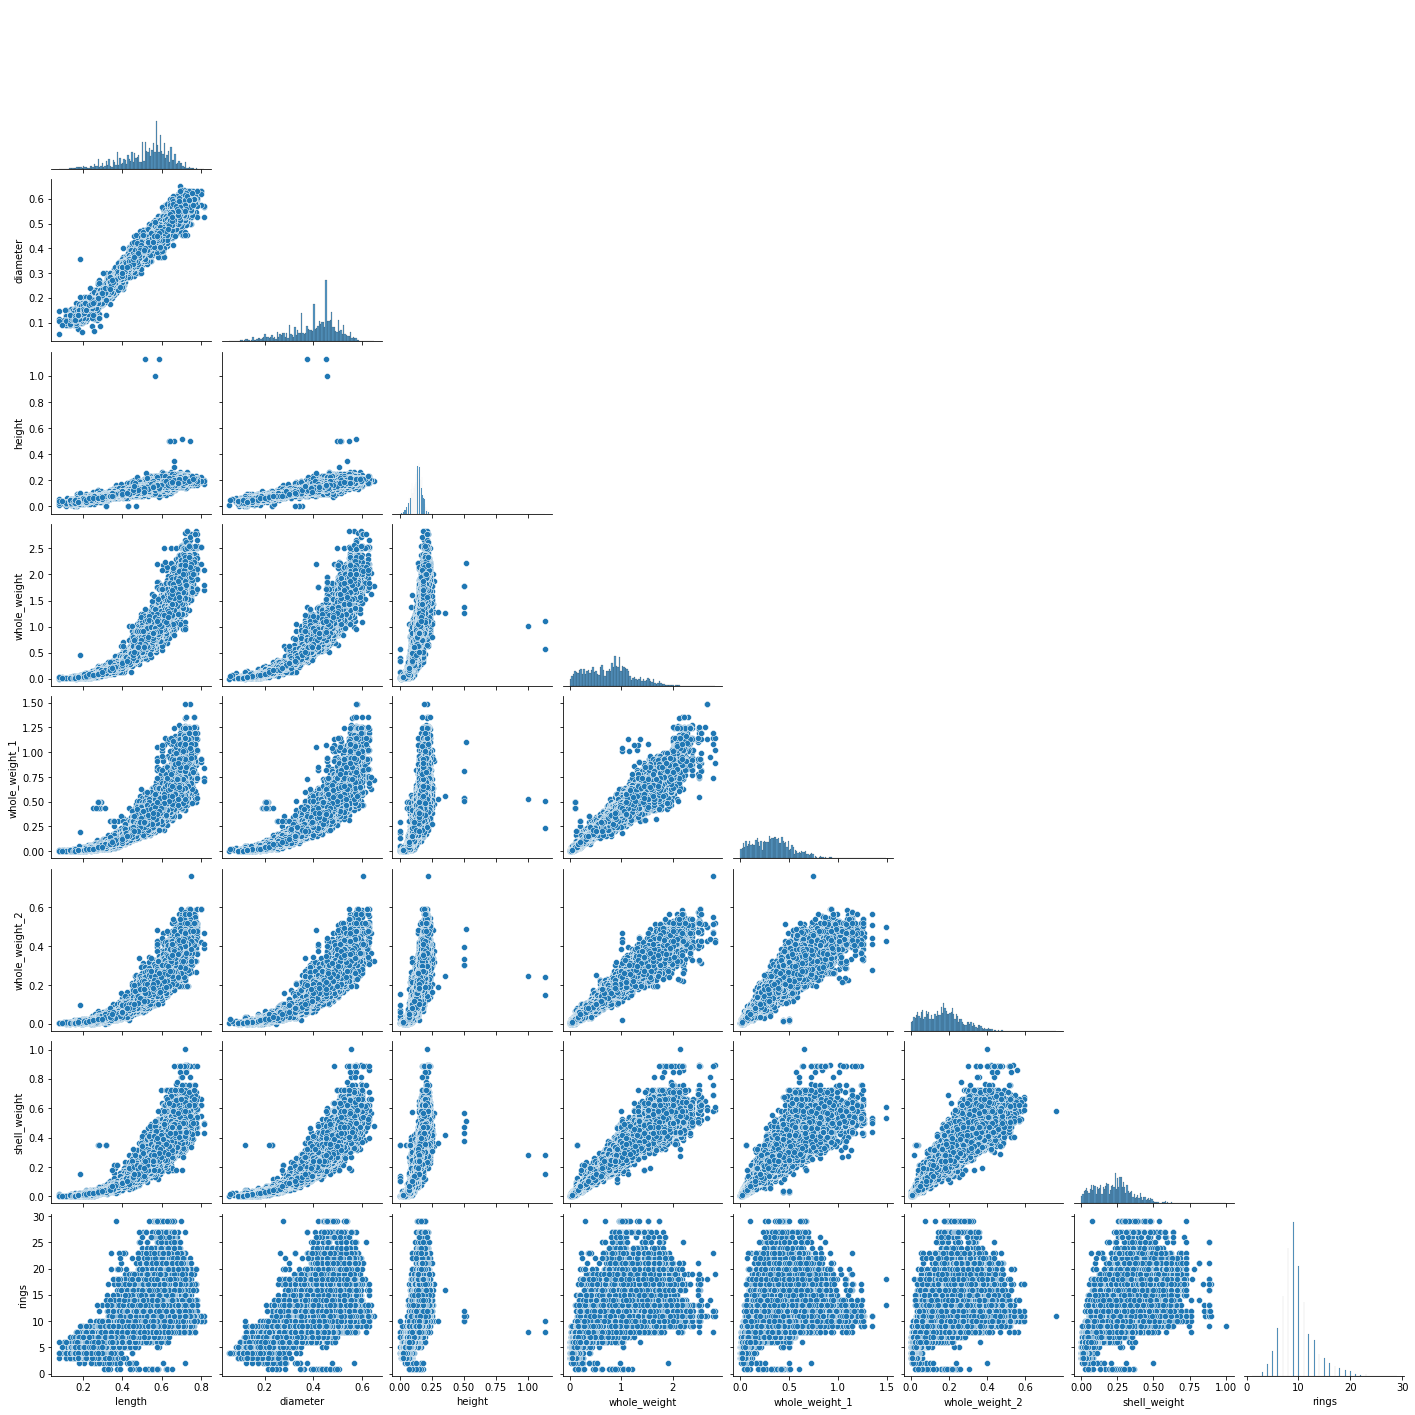

In [7]:
mlp.pairplot(df=train_df.reset_index(),
             numerical_features=numerical_features,
             target_type=target_type,
             target_col=target,
             sample=0.5)

#### Numerical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the numerical features

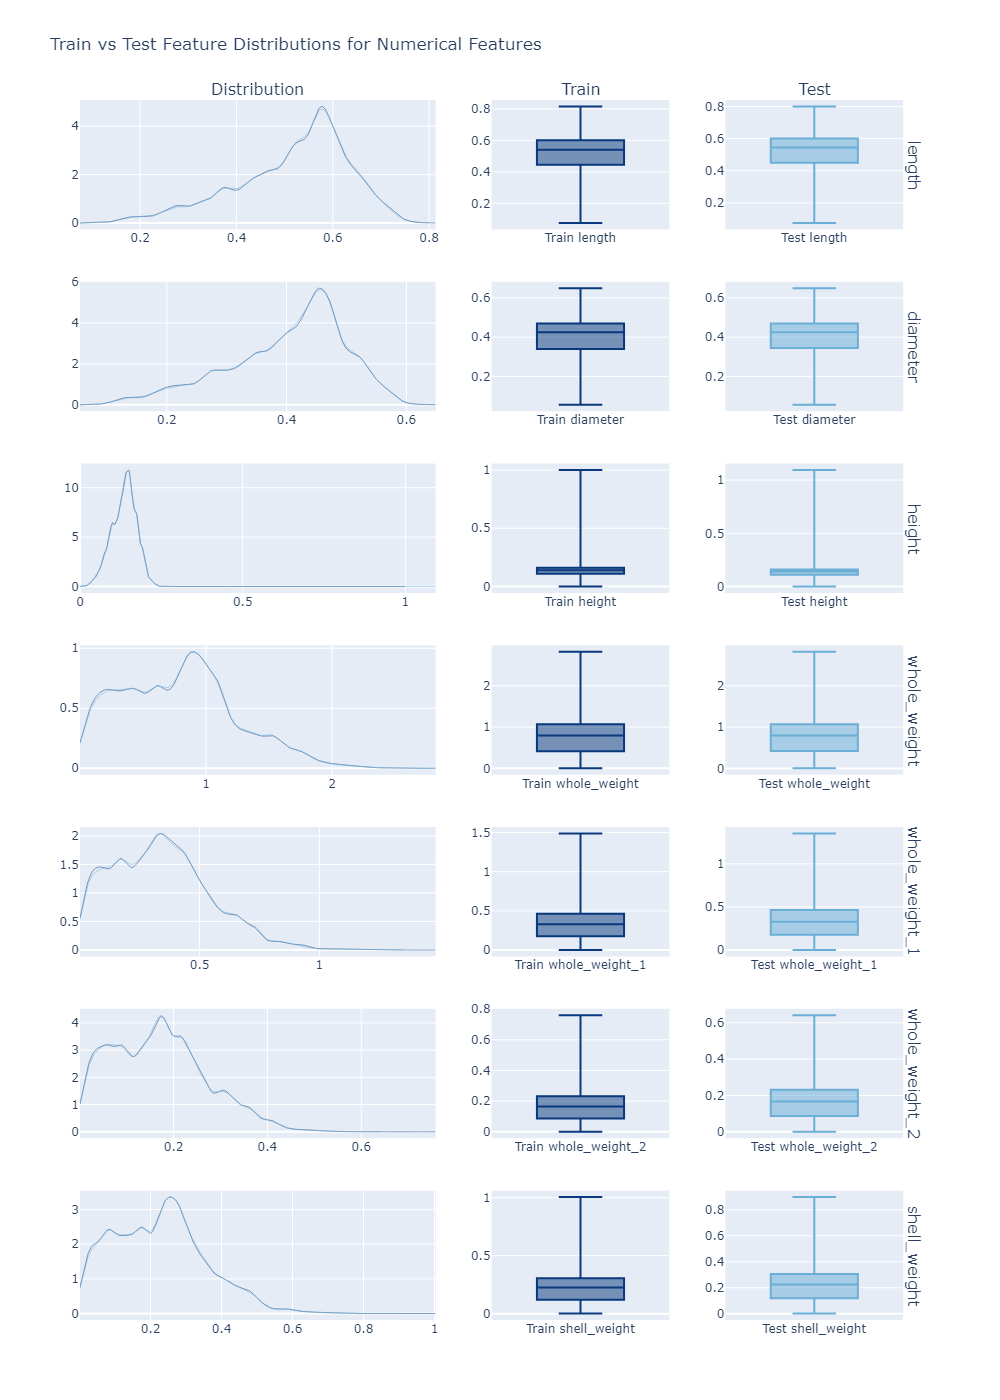

In [9]:
mlp.train_test_distribution_plots(train_df,
                                  test_df,
                                  numerical_features,
                                  sample=0.5,
                                  renderer='png'
                                  ) 

#### Categorical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the cateorical features

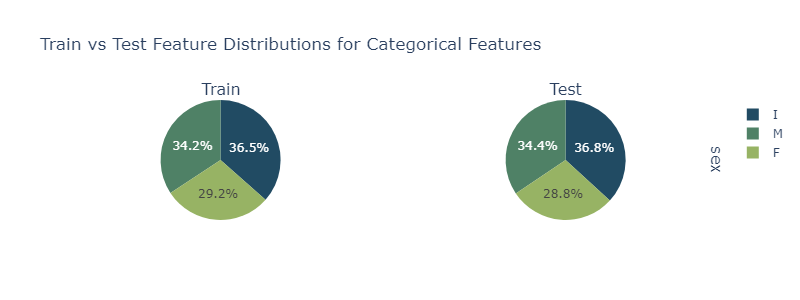

In [8]:
mlp.train_test_categorical_piecharts(train_df,
                                     test_df,
                                     categorical_features,
                                     renderer='png'
                                     )

#### Correlation Matrix

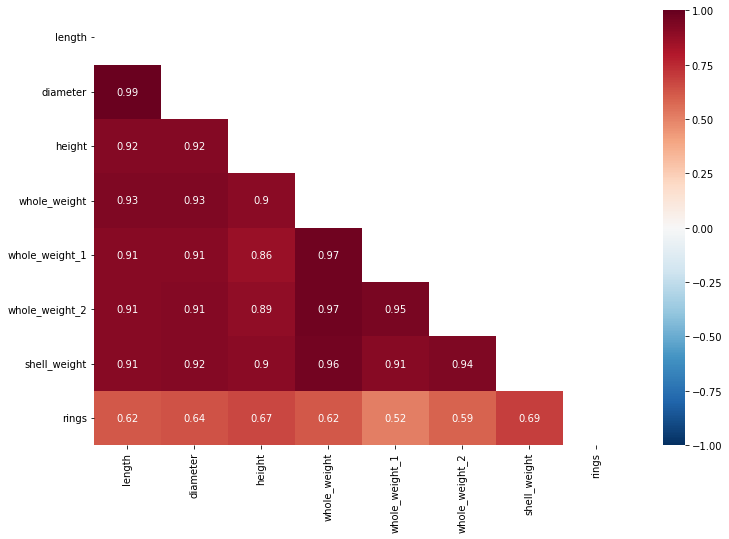

In [9]:
mlp.correlation_plot(train_df[numerical_features + [target]])

### Model Training with Optuna

#### Declaring variables needed for optimization step

In [10]:
# During the model fitting step, the optuna optimizer will include the algorithm 
# as one of the  hyperparameters of the model. It will try to find the one that 
# performs the best for our problem.

if target_type == 'continuous':    
    optimization_objective = 'regression'
    # available algorithms for regression tasks. 
    algorithms = [
                    # 'linear',
                    # 'ridge',
                    # 'histgb',                     
                    # 'extratrees', 
                    'lgb',
                    # 'xgb', 
                    # 'catboost'
                ] 
    
    # scoring for cross-validation
    optimization_scoring = 'neg_mean_squared_log_error'

elif target_type == 'binary':
    optimization_objective = 'classification'
    # available algorithms for binary classification tasks
    algorithms = [
                    # 'histgb',                     
                    # 'extratrees', 
                    'lgb',
                    # 'xgb', 
                    # 'catboost'
                ]
    # scoring for cross-validation
    optimization_scoring = 'roc_auc'

elif target_type == 'multiclass':
    optimization_objective = 'multiclass'
    # available algorithms for multiclass classification tasks
    algorithms = [
                    'histgb',                     
                    'lgb',
                ]
    # scoring for cross-validation
    optimization_scoring = 'neg_log_loss'

#### Model Optimization

In [11]:
pd.set_option('future.no_silent_downcasting', True)
with_imputation = False
with_interactions = False
with_feature_selection = False

train_df = train_df.dropna(subset=target)

if with_imputation:
    X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target, axis=1), 
                                                        train_df[target], 
                                                        test_size=0.2,
                                                        random_state=0)   
else:
    train_df_no_missing_vals = train_df.dropna().copy()
    X_train, X_test, y_train, y_test = train_test_split(train_df_no_missing_vals.drop(target, axis=1), 
                                                        train_df_no_missing_vals[target], 
                                                        test_size=0.2,
                                                        random_state=0)

# declaring our optuna study
factor = 2
# the pruner parameter helps make the optimization much faster as it will prune
# any iterations that don't look promising right from the start
study = create_study(study_name='optimization', 
                     direction='maximize',
                     pruner=SuccessiveHalvingPruner(reduction_factor=factor),
                     sampler=RandomSampler(seed=0))


# custom function to fit the model using smart hyperparameter search with optuna. This 
# parameter search is not restricted to the algorithm's hyperparameters. The algorithm
# itself is part of the parameters to be optimized. Data preprocessing decisions are 
# also included here, such as the scaling approach for numerical features, the encoding 
# technique for categorical variables, as well as feature selection.
study.optimize(lambda trial: mlp.objective(trial, 
                                           X_train, 
                                           y_train, 
                                           objective=optimization_objective,
                                           algorithms=algorithms,
                                           cv_scoring=optimization_scoring,
                                           numerical_columns=numerical_features, 
                                           categorical_columns=categorical_features,
                                           with_feature_selection=with_feature_selection,
                                           with_imputation=with_imputation, 
                                           with_interactions=with_interactions,
                                           base=factor, 
                                           n_rungs=4), 
               n_trials=100)

[I 2024-05-04 16:55:31,244] A new study created in memory with name: optimization
[I 2024-05-04 16:55:35,260] Trial 0 finished with value: -0.022577006208291464 and parameters: {'with_centering': False, 'with_scaling': True, 'categorical_encoder': 'onehot', 'algorithm': 'lgb', 'lambda_l1': 6.499698237449666e-05, 'lambda_l2': 0.006502000785097662, 'num_leaves': 113, 'max_depth': 8, 'feature_fraction': 0.9781976563006176, 'bagging_fraction': 0.6300649112954666, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 0 with value: -0.022577006208291464.
[I 2024-05-04 16:55:38,578] Trial 1 finished with value: -0.02252639792400597 and parameters: {'with_centering': False, 'with_scaling': False, 'categorical_encoder': 'onehot', 'algorithm': 'lgb', 'lambda_l1': 1.5204270129130175e-08, 'lambda_l2': 0.31158648353398066, 'num_leaves': 200, 'max_depth': 7, 'feature_fraction': 0.9871710053396584, 'bagging_fraction': 0.8794951385300341, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial

In [13]:
save_model = False
if save_model:
    file_name = 'model'
    joblib.dump(study, f"{file_name}.pkl")

In [14]:
# saving the models best parameters and trial and printing its best score
best_model_params = study.best_params
best_trial = study.best_trial
# printing the score of the best model
print(study.best_value)

-0.022475724288090436


#### Optuna trials visualizations

In [15]:
visualization.plot_optimization_history(study)

In [16]:
visualization.plot_param_importances(study, target_name="ms")

#### Instantiating the model

In [17]:
# calling the best trial and instantiating the model
model = mlp.instantiate_model(best_trial, 
                              numerical_features, 
                              categorical_features, 
                              optimization_objective, 
                              algorithms,
                              with_feature_selection=with_feature_selection,
                              with_imputation=with_imputation,
                              with_interactions=with_interactions)
model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   PassthroughTransformer()),
                                                                  ('pandarizer',
                                                                   PassthroughTransformer()),
                                                                  ('interactions',
                                                                   PassthroughTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler(with_centering=False,
                                                                                with_scaling=False))]),
                                                  ['length', 'diameter',
                                                   'height', 'whole_weight',
                                                   'whole_weight_1',
                                                   'wh...
                                                  Pipeline(steps=[('imputer',
                                                                   PassthroughTransformer()),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['sex'])])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.7410603693211891,
                               bagging_freq=1,
                               feature_fraction=0.6736901993299291,
                               lambda_l1=0.0004973188214118054,
                               lambda_l2=5.3945777886906086e-05, max_depth=7,
                               min_child_samples=64, num_leaves=69,
                               objective='regression', random_state=0,
                               verbosity=-1))])

In [18]:
# printing score on the test set
print(model.score(X_test,y_test))

0.6658230452398549


### Model Explainability with SHAP

#### Fitting the model on preprocessed data

In [19]:
best_model_params

{'with_centering': False,
 'with_scaling': False,
 'categorical_encoder': 'onehot',
 'algorithm': 'lgb',
 'lambda_l1': 0.0004973188214118054,
 'lambda_l2': 5.3945777886906086e-05,
 'num_leaves': 69,
 'max_depth': 7,
 'feature_fraction': 0.6736901993299291,
 'bagging_fraction': 0.7410603693211891,
 'bagging_freq': 1,
 'min_child_samples': 64}

#### Applying preprocessing steps to our dataset and Fitting the model
To be able to compute the shap values we need the preprocessed dataset and the chosen model. We'll use the best_model_params dictionary to retrieve them

In [20]:
final_processor = model.named_steps['processor']
final_learner = model.named_steps['model']

X_train_preprocessed = final_processor.transform(X_train)
X_test_preprocessed = final_processor.transform(X_test)

if with_imputation:
    train_df_preprocessed = final_processor.transform(train_df)
else:
    train_df_preprocessed = final_processor.transform(train_df_no_missing_vals)

if with_interactions:
    processed_numerical_features = final_processor.named_transformers_['numerical_pipeline']['interactions'].get_feature_names_out()
else:
    processed_numerical_features = numerical_features

if with_imputation:
    get_features_step = 'imputer'
else:
    get_features_step = 'encoder'
processed_categorical_features = final_processor.named_transformers_['categorical_pipeline'][get_features_step].get_feature_names_out().tolist()

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, 
                                    columns=processed_numerical_features + processed_categorical_features, 
                                    index=X_train.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, 
                                   columns=processed_numerical_features + processed_categorical_features, 
                                   index=X_test.index)
train_df_preprocessed = pd.DataFrame(train_df_preprocessed, 
                                     columns=processed_numerical_features + processed_categorical_features, 
                                     index=train_df.index)

X_train_preprocessed

length  diameter  height  whole_weight  whole_weight_1  whole_weight_2  \
id                                                                              
38059   0.580     0.400   0.145        0.8915          0.3915          0.1820   
26114   0.525     0.405   0.115        0.7095          0.3155          0.1455   
19998   0.625     0.475   0.160        1.0185          0.4775          0.2255   
18162   0.575     0.450   0.175        1.0225          0.3675          0.2155   
56716   0.570     0.460   0.165        0.8270          0.2985          0.2260   
...       ...       ...     ...           ...             ...             ...   
21243   0.190     0.170   0.040        0.0210          0.0080          0.0065   
45891   0.275     0.200   0.075        0.1365          0.0565          0.0240   
42613   0.530     0.415   0.120        0.5885          0.2645          0.1415   
43567   0.405     0.305   0.100        0.2665          0.1165          0.0585   
68268   0.630     0.470   0.165        1.0115          0.4815          0.2245   

       shell_weight  sex_1  sex_2  sex_3  
id                                        
38059        0.2265    1.0    0.0    0.0  
26114        0.1750    0.0    1.0    0.0  
19998        0.2635    0.0    0.0    1.0  
18162        0.3400    0.0    0.0    1.0  
56716        0.2350    0.0    0.0    1.0  
...             ...    ...    ...    ...  
21243        0.0065    1.0    0.0    0.0  
45891        0.0350    1.0    0.0    0.0  
42613        0.1700    0.0    0.0    1.0  
43567        0.0850    0.0    0.0    1.0  
68268        0.2900    0.0    1.0    0.0  

[72492 rows x 10 columns]

#### Calculating Shap Values

In [21]:
explainer = shap.TreeExplainer(final_learner)
# explainer = shap.Explainer(final_learner)
shap_values = explainer.shap_values(X_train_preprocessed, y_train)

# explainer = shap.KernelExplainer(final_learner.predict, X_train_preprocessed)
# shap_values = explainer.shap_values(X_train_preprocessed)

#### Shap summary plot

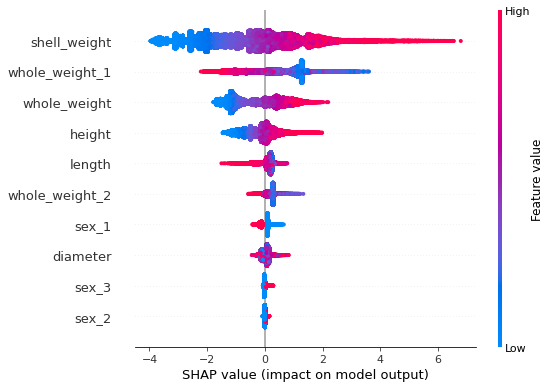

In [22]:
if target_type == 'continuous':     # graph not supported for multiclass
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      feature_names=X_train_preprocessed.columns, 
                      plot_type='dot')
else:
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      plot_type="bar", 
                      feature_names = X_train_preprocessed.columns)

    for i, tclass in enumerate(target_classes):
        shap.summary_plot(shap_values[i], 
                  X_train_preprocessed, 
                  plot_type="dot", 
                  feature_names = X_train_preprocessed.columns,
                  show=False) 
        plt.title(f'Shap values for {target} {tclass}')
        plt.show() 


#### Partial Dependence Plots

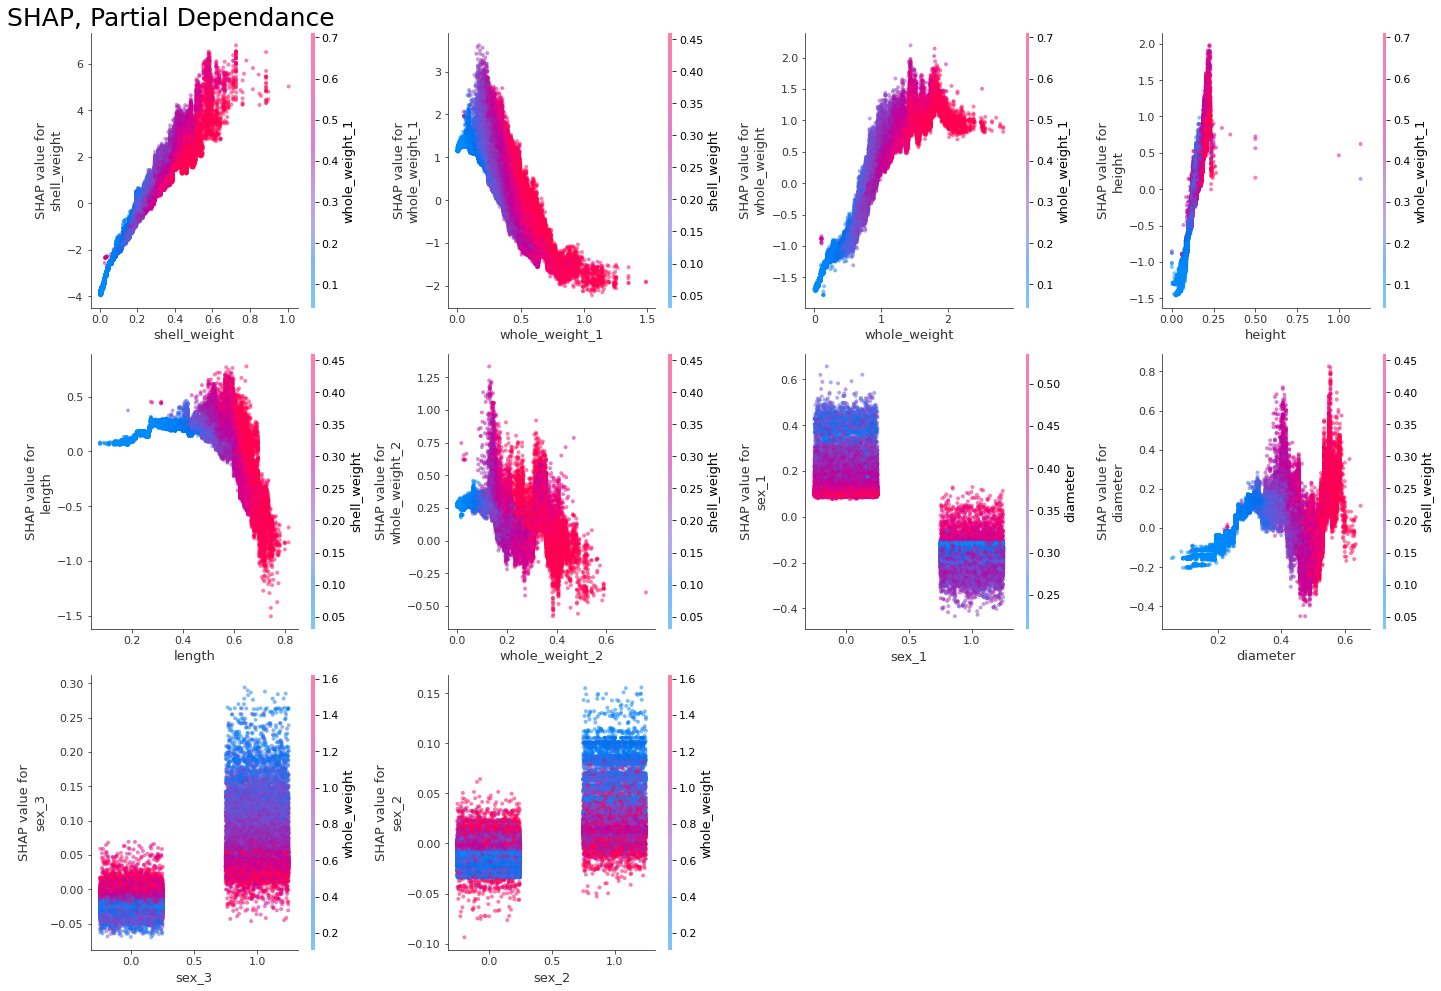

In [23]:
if target_type != 'continuous':
    # producing one graph for each class
    for i, tclass in enumerate(target_classes):
        mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values[i], n_charts=12) 
else:
    mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values, n_charts=12)

Takeaways from the previous graphs: 

### Model Predictions Analysis

#### Train Set

In [24]:
if target_type == 'continuous':
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed
                                           )
else:
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed, 
                                           label_encoder=le)

train_results

id  length  diameter  height  whole_weight  whole_weight_1  \
0      38059   0.580     0.400   0.145        0.8915          0.3915   
1      26114   0.525     0.405   0.115        0.7095          0.3155   
2      19998   0.625     0.475   0.160        1.0185          0.4775   
3      18162   0.575     0.450   0.175        1.0225          0.3675   
4      56716   0.570     0.460   0.165        0.8270          0.2985   
...      ...     ...       ...     ...           ...             ...   
72487  21243   0.190     0.170   0.040        0.0210          0.0080   
72488  45891   0.275     0.200   0.075        0.1365          0.0565   
72489  42613   0.530     0.415   0.120        0.5885          0.2645   
72490  43567   0.405     0.305   0.100        0.2665          0.1165   
72491  68268   0.630     0.470   0.165        1.0115          0.4815   

       whole_weight_2  shell_weight  sex_1  sex_2  sex_3  rings_prediction  \
0              0.1820        0.2265    1.0    0.0    0.0          8.951879   
1              0.1455        0.1750    0.0    1.0    0.0          8.670346   
2              0.2255        0.2635    0.0    0.0    1.0          8.826240   
3              0.2155        0.3400    0.0    0.0    1.0         15.296653   
4              0.2260        0.2350    0.0    0.0    1.0         12.246530   
...               ...           ...    ...    ...    ...               ...   
72487          0.0065        0.0065    1.0    0.0    0.0          4.134519   
72488          0.0240        0.0350    1.0    0.0    0.0          5.858634   
72489          0.1415        0.1700    0.0    0.0    1.0          9.025837   
72490          0.0585        0.0850    0.0    0.0    1.0          8.659073   
72491          0.2245        0.2900    0.0    1.0    0.0          9.306585   

       rings     error  
0          9  0.048121  
1          8 -0.670346  
2          9  0.173760  
3         10 -5.296653  
4         11 -1.246530  
...      ...       ...  
72487      4 -0.134519  
72488      6  0.141366  
72489     10  0.974163  
72490      8 -0.659073  
72491      9 -0.306585  

[72492 rows x 14 columns]

##### Overall Observations vs. Predictions plot

In [25]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=train_results[target],
                              y_pred=train_results[target + '_prediction'],
                              labels=target_classes)

In [26]:
import plotly.express as px
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

print(r2_score(train_results[target], train_results[f"{target}_prediction"]))
print(mean_squared_log_error(train_results[target], train_results[f"{target}_prediction"]))


if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(train_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=train_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target,
                                                 renderer='png'
                                                 )


0.6905921789885954
0.02102219373299796


##### Single prediction waterfall plot

In [27]:
shap_explainer_values_train = explainer(X_train_preprocessed, y_train)

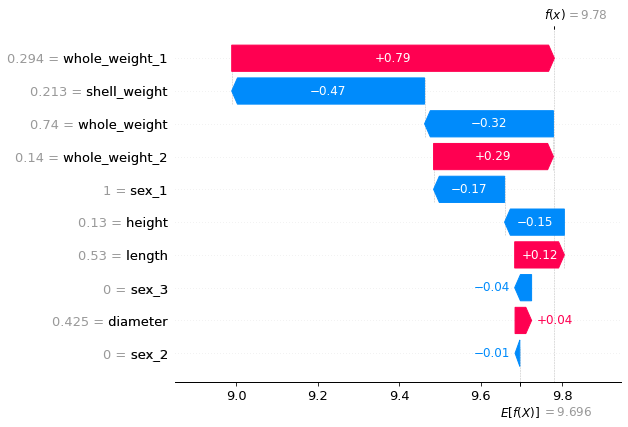

In [28]:
datapoint_id = 1485
idx = train_results[train_results.id == datapoint_id].index[0]
if target_type == 'continuous':
    shap.waterfall_plot(shap_explainer_values_train[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_train[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

#### Test Set

In [29]:
if target_type == 'continuous':
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed)
else:
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed, 
                                          label_encoder=le)

test_results

id  length  diameter  height  whole_weight  whole_weight_1  \
0      19402   0.370     0.280   0.095        0.1975          0.0735   
1       2753   0.410     0.300   0.080        0.3045          0.1190   
2      85629   0.425     0.345   0.100        0.3665          0.1250   
3       7777   0.500     0.400   0.130        0.6615          0.2690   
4      90199   0.565     0.430   0.150        0.8380          0.4110   
...      ...     ...       ...     ...           ...             ...   
18118  12490   0.520     0.425   0.145        0.8115          0.3695   
18119  56089   0.705     0.575   0.515        2.2100          1.1075   
18120  74706   0.655     0.535   0.160        1.4045          0.6860   
18121   8166   0.375     0.270   0.090        0.2155          0.1145   
18122  38921   0.525     0.400   0.125        0.7045          0.3470   

       whole_weight_2  shell_weight  sex_1  sex_2  sex_3  rings_prediction  \
0              0.0515        0.0600    1.0    0.0    0.0          6.842391   
1              0.0570        0.0800    1.0    0.0    0.0          6.846067   
2              0.0800        0.1170    1.0    0.0    0.0          7.758414   
3              0.1415        0.1800    0.0    0.0    1.0          9.765511   
4              0.1960        0.2170    0.0    0.0    1.0          8.870118   
...               ...           ...    ...    ...    ...               ...   
18118          0.1695        0.2400    0.0    1.0    0.0          9.764845   
18119          0.4865        0.5120    0.0    0.0    1.0         10.694050   
18120          0.3020        0.4395    0.0    1.0    0.0         11.463813   
18121          0.0405        0.0500    1.0    0.0    0.0          6.597383   
18122          0.1415        0.1940    1.0    0.0    0.0          8.334423   

       rings     error  
0          6 -0.842391  
1          7  0.153933  
2          9  1.241586  
3         10  0.234489  
4         10  1.129882  
...      ...       ...  
18118     10  0.235155  
18119     11  0.305950  
18120     10 -1.463813  
18121      8  1.402617  
18122      9  0.665577  

[18123 rows x 14 columns]

##### Overall Observations vs. Predictions plot

In [30]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=test_results[target],
                              y_pred=test_results[target + '_prediction'],
                              labels=target_classes)

In [31]:
from sklearn.metrics import r2_score
print(r2_score(test_results[target], test_results[f"{target}_prediction"]))
print(mean_squared_log_error(test_results[target], test_results[f"{target}_prediction"].round(0)))

if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(test_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=test_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target,
                                                 renderer='png'
                                                 )


0.6658230452398549
0.023650729742593416


##### Single prediction waterfall plot

In [44]:
shap_explainer_values_test = explainer(X_test_preprocessed, y_test)

In [ ]:
datapoint_id = 1089726986
idx = test_results[test_results.entity_id == datapoint_id].index[0]
if target_type != 'multiclass':
    shap.waterfall_plot(shap_explainer_values_test[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_test[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

### Conclusion